In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp  


import numpy as np  
import matplotlib.pyplot as plt  

from asterias.core import LimbDarkeningCoefficients

In [12]:
ld = LimbDarkeningCoefficients(
    wavelength_ranges=jnp.array([[6000, 7000], [7000, 8000]]),
    filter_wavelengths=jnp.arange(5000, 10000),
    filter_throughput=jnp.ones(5000),
    mh_lower_limit=0.0,
    mh_upper_limit=0.3,
    teff_lower_limit=5000,
    teff_upper_limit=6000,
    logg_lower_limit=4.0,
    logg_upper_limit=4.5,
    stellar_grid="kurucz",
    poly_deg=10,
    ld_data_path="/Users/cassese/Downloads/tmpdata",
    verbose=True,
)

Checking for/downloading 40 files


'/Users/cassese/Downloads/tmpdata/kurucz/MH0.2/teff5000/logg4.0/kurucz_spectra.dat'

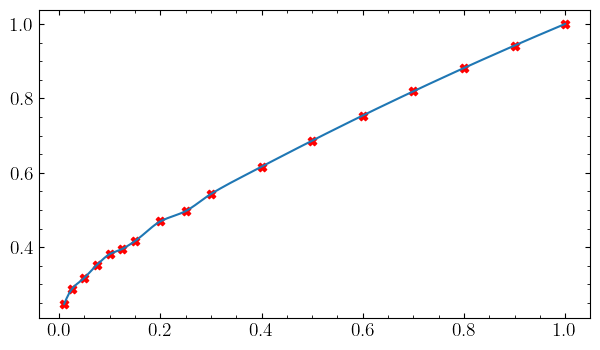

In [13]:
star = 20
plt.plot(ld.dense_mus, ld.interpolated_profiles[star,0,:])
plt.scatter(ld.mus, ld.stellar_profiles[star,0,:], marker="X", c="r")
ld.stellar_files[star]

In [14]:
coeffs = ld.get_ldcs(mh=0.2, teff=5000.0, logg=4.0)
coeffs

Array([[-1.18233544e+02,  6.63211671e+02, -1.62919747e+03,
         2.30240285e+03, -2.06571520e+03,  1.22316559e+03,
        -4.80578736e+02,  1.22666703e+02, -1.95432766e+01,
         2.59330969e+00,  2.27859192e-01],
       [-6.46944745e+02,  3.55360502e+03, -8.42475234e+03,
         1.12853668e+04, -9.39257072e+03,  5.02994684e+03,
        -1.73456364e+03,  3.74354132e+02, -4.77837088e+01,
         4.06591085e+00,  2.75608171e-01]], dtype=float64)

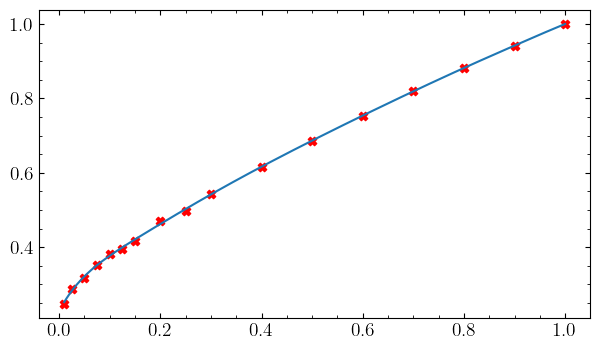

In [15]:
model = jnp.polyval(p=coeffs[0], x=ld.dense_mus)
plt.plot(ld.dense_mus, model)
plt.scatter(ld.mus, ld.stellar_profiles[star,0,:], marker="X", c="r")


In [16]:
jax.jacfwd(ld.get_ldcs)(0.2, 5000.0, 4.0)

Array([[-5.02486630e+03,  2.65623954e+04, -6.02340939e+04,
         7.64992061e+04, -5.95774331e+04,  2.92719930e+04,
        -8.99013724e+03,  1.65103872e+03, -1.65707606e+02,
         7.72813849e+00, -1.31365827e-01],
       [-3.08900636e+03,  1.64703017e+04, -3.70901928e+04,
         4.58868851e+04, -3.39803027e+04,  1.53972891e+04,
        -4.19829510e+03,  6.55796277e+02, -5.47888868e+01,
         2.39247069e+00, -6.98484941e-02]], dtype=float64)

In [ ]:
from scipy.interpolate import interp1d
from scipy.special import roots_legendre

np.random.seed(0)

stellar_wavelengths = np.arange(5_000, 10_000)
stellar_intensities = np.random.rand(len(stellar_wavelengths))

wavelength_range = np.array([6_000, 8_000])

s_wavelengths = np.arange(5_000, 9_000)
s_throughputs = np.ones_like(s_wavelengths)

wavelength_range = np.sort(np.array(wavelength_range))
s_mask = np.logical_and(
    wavelength_range[0] < s_wavelengths, s_wavelengths < wavelength_range[1]
)

i_mask = np.logical_and(
    wavelength_range[0] < stellar_wavelengths, stellar_wavelengths < wavelength_range[1]
)

s_wvs = s_wavelengths[s_mask]
s_thp = s_throughputs[s_mask]
i_wvs = stellar_wavelengths[i_mask]
i_int = stellar_intensities[i_mask]

s_interp_func = interp1d(
    s_wvs, s_thp, kind="linear", bounds_error=False, fill_value=0.0
)


# Pre-compute Gauss-legendre roots and rescale to lims.
roots, weights = roots_legendre(500)
a = wavelength_range[0]
b = wavelength_range[1]
t = (b - a) / 2 * roots + (a + b) / 2


i_interp_func = interp1d(
    i_wvs, i_int, kind="linear", bounds_error=False, fill_value=0.0
)


def integrand(_lambda):
    return s_interp_func(_lambda) * i_interp_func(_lambda)


# Approximate integral.
I_mu = (b - a) / 2.0 * integrand(t).dot(weights)
I_mu